# Numerical PDE solution using Physics-informed neural networks

In [1]:
import torch
import numpy as np
from heat_612 import heat_nn
import time

np.random.seed(238)
torch.manual_seed(301)

In [2]:
# for plotting / animation

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import animation, rc, rcParams
from IPython.display import HTML
from mpi4py import MPI

# 1D Heat equation

In [7]:
### Choose if you want to solve the PDE \partial_t - \kappa \Delta u = 0 or 
### \partial_t - \kappa \Delta u = f with f(x) = \sin ( \pi x ).

# in the first case, example = 0, else example = 1
example = 1

In [8]:
### PDE parameters

# dimension
dim=1

# diffusion coefficient
kappa = 0.1

# initial condition
u_0 = lambda x: torch.sin(torch.pi * x) + torch.sin(4 * torch.pi * x)

# right hand side of the equation
if example == 0:
    rhs = lambda x, t: 0
elif example == 1:
    rhs = lambda x, t: torch.sin(torch.pi * x)

# analytic solution
if example == 0:
    u_analytic = lambda x, t: torch.sin(torch.pi * x) * torch.exp(- torch.pi**2 * kappa * t
                    ) + torch.sin(4 * torch.pi * x) * torch.exp(- 16 * torch.pi**2 * kappa * t)
elif example == 1:
    u_analytic = lambda x, t: (1 - 1 / (kappa * torch.pi**2)) * torch.sin(torch.pi * x) * torch.exp(
                    -torch.pi**2 * kappa * t) + torch.sin(4 * torch.pi * x) * torch.exp(
                    - 16 * torch.pi**2 * kappa * t) + 1 / (0.1 * torch.pi**2) * torch.sin(
                    torch.pi * x)

In [9]:
### Construct the neural network and train it

layers = [128, 128, 64, 64, 32, 1]
#in this example: the output layer uses identity as activation func and all the hidden layers use tanh
activations = [torch.tanh]*(len(layers)-1) + [None]

pde_nn = heat_nn(layers, activations, dim, u_0, kappa, rhs)
pde_nn.set_analytic_solution(u_analytic)
N_colloc = 100
pde_nn.set_data(N_colloc)

# measure time of training
start = time.perf_counter()

# train with Adam at first to get near the optimum
pde_nn.train(lr=1e-2, weight_decay=0.0, epochs = 400, opt_time_scale =True, print_epochs=50)
# afterwards, continue with L-BFGS
# L-BFGS needs approximately 100 epochs, 30 iterations for kappa = 1
# if kappa = 0.1, better choose more iterations, less epochs
pde_nn.train_lbfgs(lr=1, opt_time_scale = True, epochs=10, max_iter=50)

end = time.perf_counter()
print("Runtime: ", end - start)

Epoch 0, Loss: 47.476147, MSE: 0.223823
Epoch 50, Loss: 14.817608, MSE: 0.044154
Epoch 100, Loss: 4.476169, MSE: 0.018685
Epoch 150, Loss: 3.396657, MSE: 0.011501
Epoch 200, Loss: 2.273036, MSE: 0.008745
Epoch 250, Loss: 1.828878, MSE: 0.007272
Epoch 300, Loss: 1.940436, MSE: 0.009802
Epoch 350, Loss: 1.589561, MSE: 0.004899
Epoch 399, Loss: 1.275252, MSE: 0.003859
Epoch 0, Loss: 0.111087, MSE: 0.000092
Epoch 1, Loss: 0.008969, MSE: 0.000005
Epoch 2, Loss: 0.001693, MSE: 0.000001
Epoch 3, Loss: 0.000757, MSE: 0.000000
Epoch 4, Loss: 0.000347, MSE: 0.000000
Epoch 5, Loss: 0.000213, MSE: 0.000000
Epoch 6, Loss: 0.000140, MSE: 0.000000
Epoch 7, Loss: 0.000111, MSE: 0.000000
Epoch 8, Loss: 0.000085, MSE: 0.000000
Epoch 9, Loss: 0.000070, MSE: 0.000000
Runtime:  523.3135360190063


In [10]:
### error measured in L^2 and L^{\infty} norm
L_2_err = pde_nn.L_2_error()
L_infty_err = pde_nn.L_infty_error()
print("L^2 error:        ", L_2_err)
print("L_^{infty}_error: ", L_infty_err)

L^2 error:         6.256933e-05
L_^{infty}_error:  0.00040334463


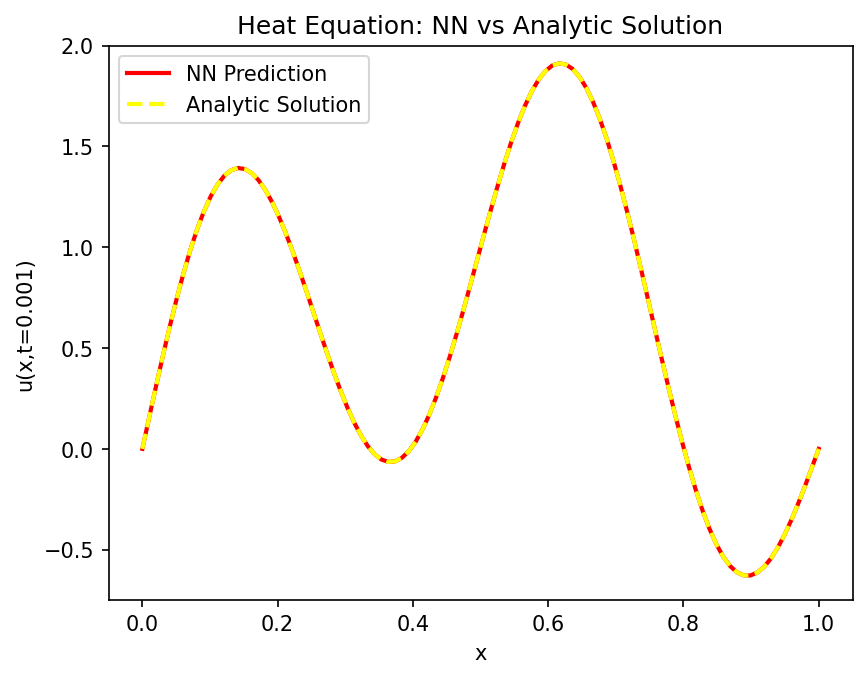

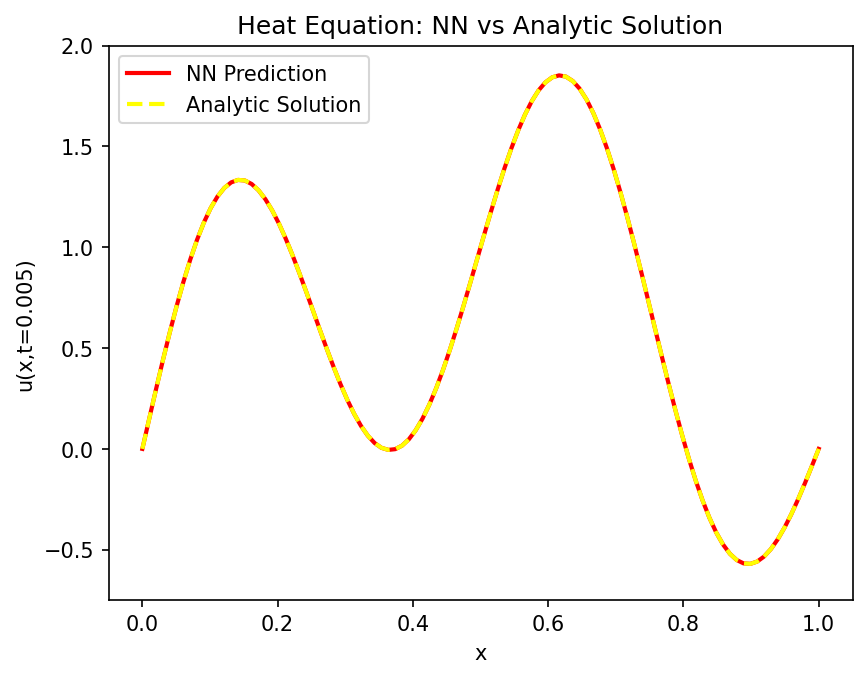

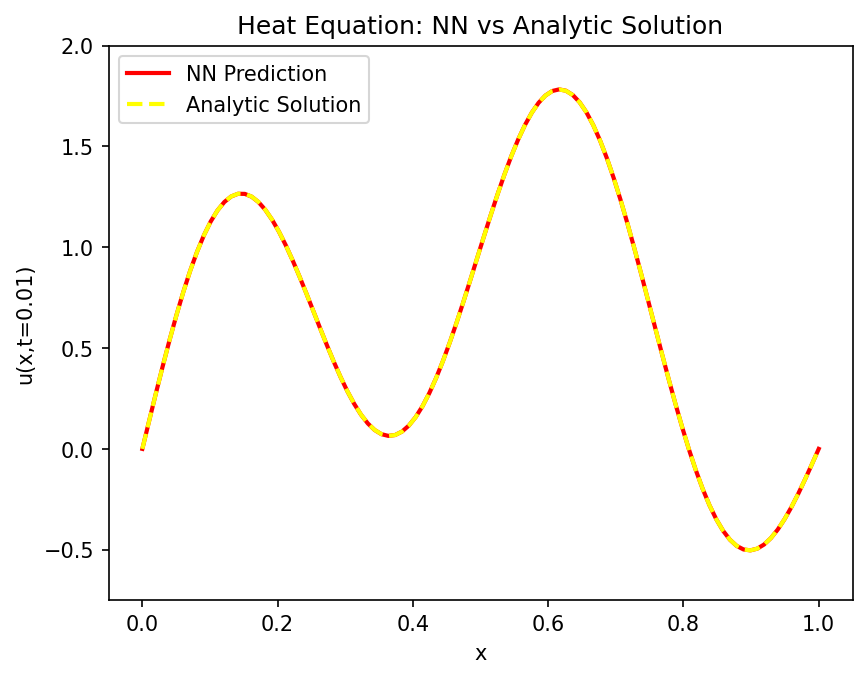

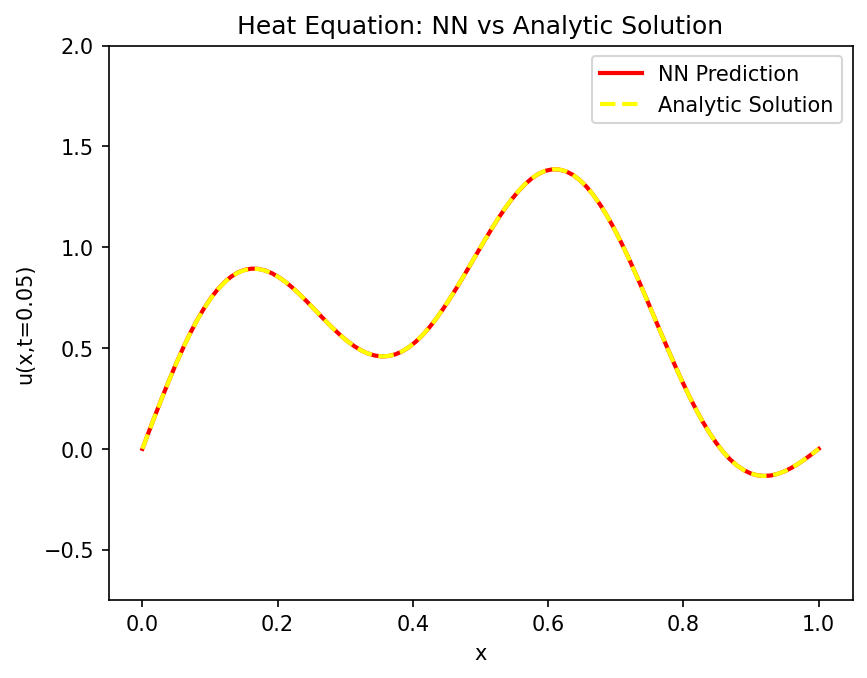

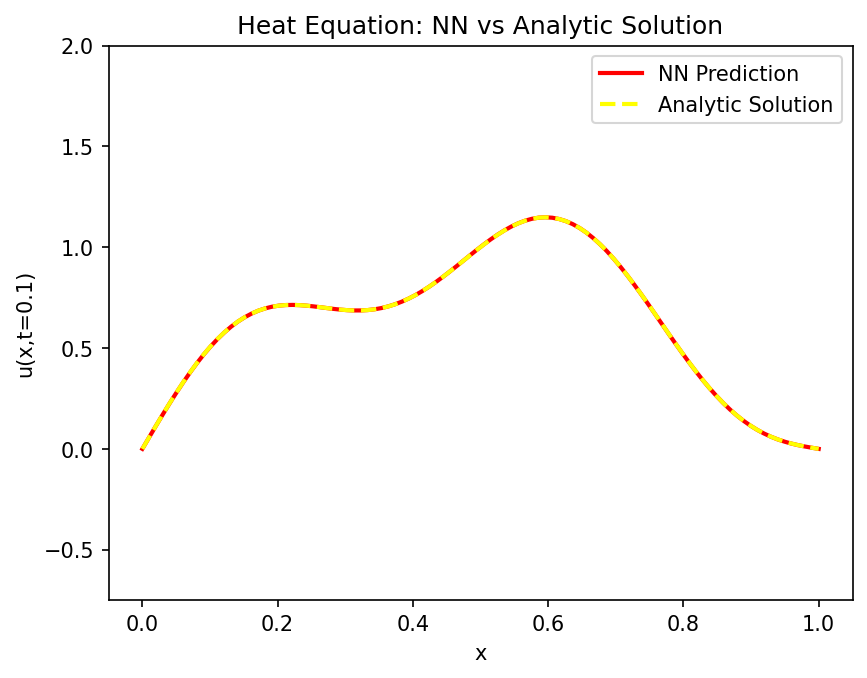

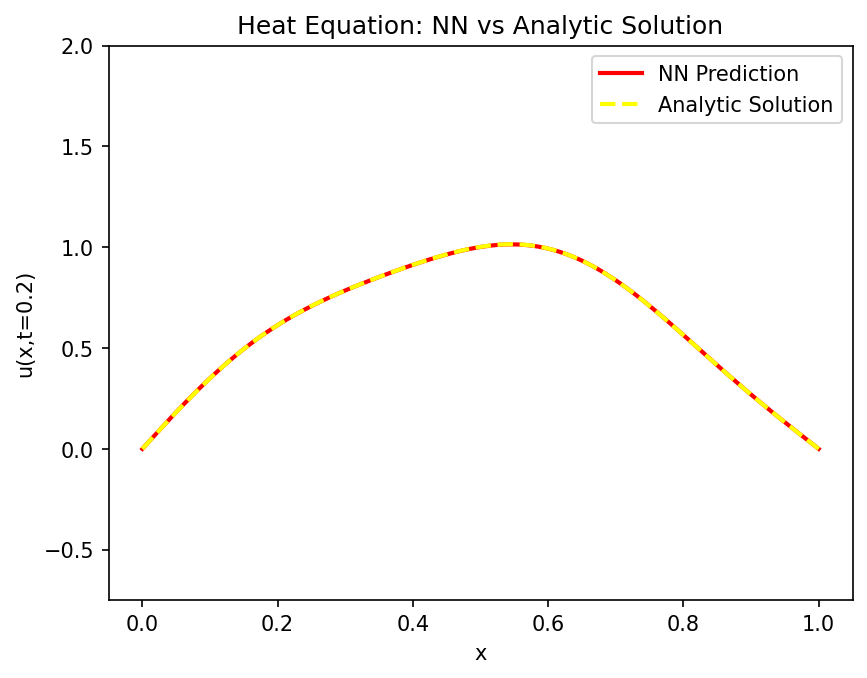

L^2 error:         0.0004327696
L_^{infty}_error:  0.0012016892
1.8728954e-07
1.1171307e-07


In [ ]:
### Plot results

for t in [0.001, 0.005, 0.01, 0.05, 0.1, 0.2]:
    x_test = torch.linspace(0,1,100).view(-1,1)
    t_test = torch.tensor([[t]]*100)  # t=0.5
    u_pred = pde_nn.trial_solution(x_test, t_test).detach().numpy()

    # compare results with analytic solution

    x_np = x_test.numpy().flatten()  # convert to 1D array for plotting
    t_val = t
    u_analytic_val = pde_nn.u_analytic(x_test, t_test)

    # Plot neural network approximation and analytic solution
    plt.figure(dpi=150)
    plt.plot(x_np, u_pred, label='NN Prediction', color='red', linewidth=2)
    plt.plot(x_np, u_analytic_val, '--', label='Analytic Solution', color='yellow', linewidth=2)
    plt.xlabel('x')
    plt.ylabel(f'u(x,t={t})')
    plt.ylim(-0.75, 2.0)
    plt.title('Heat Equation: NN vs Analytic Solution')
    plt.legend()
    plt.show()

### Animation for the 1D solution

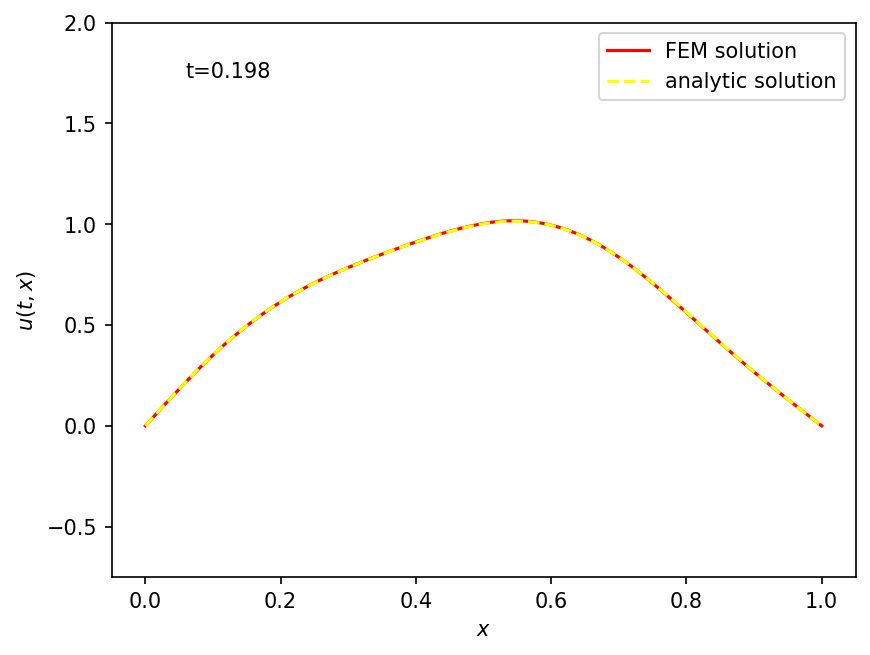

In [5]:
###===============================================================================================
### create an animation comparing the PINN and analytic solution

x = np.linspace(0, 1, 100)
fig, ax = plt.subplots(dpi=150)

# plot PINN and analytic solution together
x_test = torch.linspace(0,1,100).view(-1,1)
# start at t=0
t_test = torch.tensor([[0]]*100) 
u_pred = pde_nn.trial_solution(x_test, t_test).detach().numpy()

# compare results with analytic solution

x_np = x_test.numpy().flatten()  # convert to 1D array for plotting
u_analytic_val = pde_nn.u_analytic(x_test, t_test)

line_1, = ax.plot(x_test, u_pred, color='red', label='FEM solution')
line_2, = ax.plot(x, u_analytic_val, '--', color='yellow', label='analytic solution')
ax.set_ylim(-0.75, 2.0)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$u(t, x)$')
ax.legend(loc='upper right')
# add text which shows the current time step in each frame
time_count = ax.text(0.1, 0.9, 't=0.000', transform=ax.transAxes)
# size of time steps in animation
h = 0.002

def update(frame):
    if frame <= 10:
        ### keep initial solution for first 10 frames
        y = u_pred
        z = u_analytic_val
        line_1.set_ydata(y)
        line_2.set_ydata(z)
        time_count.set_text('t=0.000')
    else:

        t = (frame - 10) * h
        t_test = torch.tensor([[t]]*100) 
        y = pde_nn.trial_solution(x_test, t_test).detach().numpy() 
        z = pde_nn.u_analytic(x_test, t_test)
        line_1.set_ydata(y)
        line_2.set_ydata(z)
        time_count.set_text('t={:.3f}'.format((frame - 10) * h))
    return line_1, line_2, time_count

ani = animation.FuncAnimation(fig, update, frames=100 + 10, interval=100)
ani.save('1d_heat_equation_pinn.gif', writer='pillow')
plt.show()


# 2D Problem

In [10]:
# if example2 = 0, then right hand side i s0, else f(x, y) = \sin ( \pi x ) \sin ( \pi y )
example2 = 1

In [11]:
"""
2D Heat equation
"""

u_0 = lambda x, y: torch.sin(torch.pi * x) * torch.sin(torch.pi * y) + torch.sin(
        2 * torch.pi * x) * torch.sin(4 * torch.pi * y)

dim=2
kappa = 0.1

if example2 == 0:
    rhs = lambda x, y, t: 0
elif example2 == 1:
    rhs = lambda x, y, t: torch.sin(torch.pi * x) * torch.sin(torch.pi * y)

if example2 == 0:
    u_analytic = lambda x, y,t: torch.sin(torch.pi * x) * torch.sin(torch.pi * y) * torch.exp(
        -2 * kappa * torch.pi**2 * t) + torch.sin(2 * torch.pi * x) * torch.sin(4 * torch.pi * y 
        ) * torch.exp(-20 * kappa * torch.pi**2 * t)
elif example2 == 1:
    u_analytic = lambda x, y, t: (1 - 1 / (2 * kappa * torch.pi**2)) * torch.sin(torch.pi * x
        ) * torch.sin(torch.pi * y) * torch.exp(-2 * kappa * torch.pi**2 * t) + torch.sin(
        2 * torch.pi * x) * torch.sin(4 * torch.pi * y) * torch.exp(-20 * kappa * torch.pi**2 * t
        ) + 1 / (2 * kappa * torch.pi**2) * torch.sin(torch.pi * x) * torch.sin(torch.pi * y)

In [12]:
np.random.seed(238)
torch.manual_seed(301)

start = time.perf_counter()

layers = [128, 128, 64, 64, 32, 1]
activations = [torch.tanh]*(len(layers)-1) + [None]

pde_nn = heat_nn(layers, activations, dim, u_0, kappa, rhs)
pde_nn.set_analytic_solution(u_analytic)
N_colloc = 30
pde_nn.set_data(N_colloc)

pde_nn.train(lr=1e-2, weight_decay=0.0, epochs = 500, opt_time_scale =True, print_epochs=50)
pde_nn.train_lbfgs(lr=1, opt_time_scale = True, epochs=20, max_iter=50)

x_test = torch.linspace(0,1,100).view(-1,1)
y_test = torch.linspace(0,1,100).view(-1,1)
t_test = torch.tensor([[0.001]]*100)  # t=0.001
u_pred = pde_nn.trial_solution(x_test, y_test, t_test).detach().numpy()

end = time.perf_counter()
print("Runtime: ", end - start)

Epoch 0, Loss: 35.890865, MSE: 0.083758
Epoch 50, Loss: 34.631104, MSE: 0.084561
Epoch 100, Loss: 21.455061, MSE: 0.047841
Epoch 150, Loss: 11.523842, MSE: 0.022731
Epoch 200, Loss: 9.209934, MSE: 0.019232
Epoch 250, Loss: 8.067052, MSE: 0.021144
Epoch 300, Loss: 7.133018, MSE: 0.013458
Epoch 350, Loss: 6.420351, MSE: 0.015765
Epoch 400, Loss: 5.916049, MSE: 0.015960
Epoch 450, Loss: 5.384062, MSE: 0.009963
Epoch 499, Loss: 5.238029, MSE: 0.015277
Epoch 0, Loss: 3.660580, MSE: 0.006182
Epoch 1, Loss: 1.896073, MSE: 0.002609
Epoch 2, Loss: 1.152403, MSE: 0.001250
Epoch 3, Loss: 0.808381, MSE: 0.000722
Epoch 4, Loss: 0.599714, MSE: 0.000481
Epoch 5, Loss: 0.450868, MSE: 0.000305
Epoch 6, Loss: 0.363779, MSE: 0.000200
Epoch 7, Loss: 0.303363, MSE: 0.000165
Epoch 8, Loss: 0.261363, MSE: 0.000117
Epoch 9, Loss: 0.219956, MSE: 0.000105
Epoch 10, Loss: 0.185928, MSE: 0.000071
Epoch 11, Loss: 0.164320, MSE: 0.000072
Epoch 12, Loss: 0.140484, MSE: 0.000057
Epoch 13, Loss: 0.122331, MSE: 0.00005

In [13]:
### error measured in L^2 and L^{\infty} norm
L_2_err = pde_nn.L_2_error()
L_infty_err = pde_nn.L_infty_error()
print("L^2 error:        ", L_2_err)
print("L_^{infty}_error: ", L_infty_err)

L^2 error:         0.0016975877
L_^{infty}_error:  0.0428122


### Plot of the numeric solution

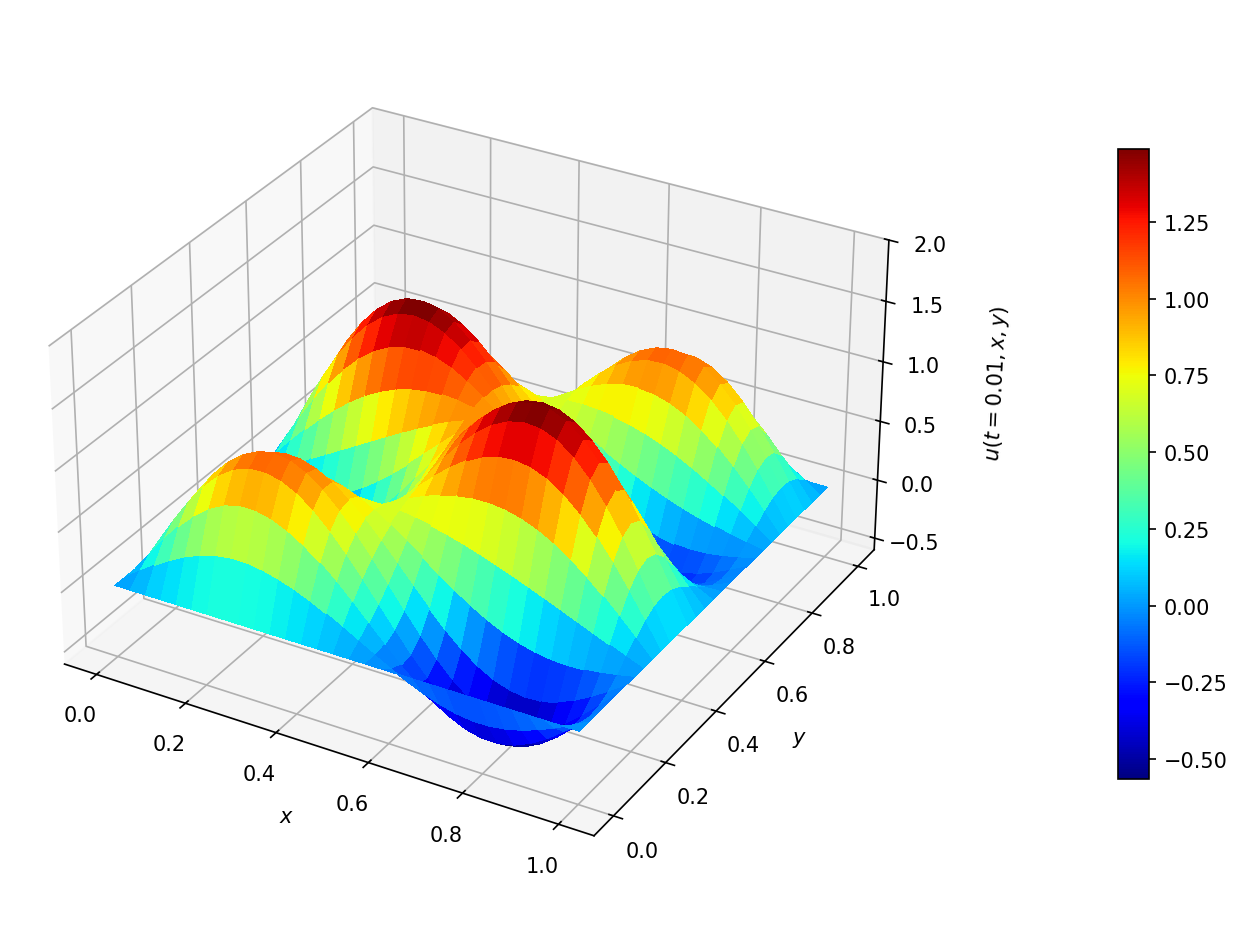

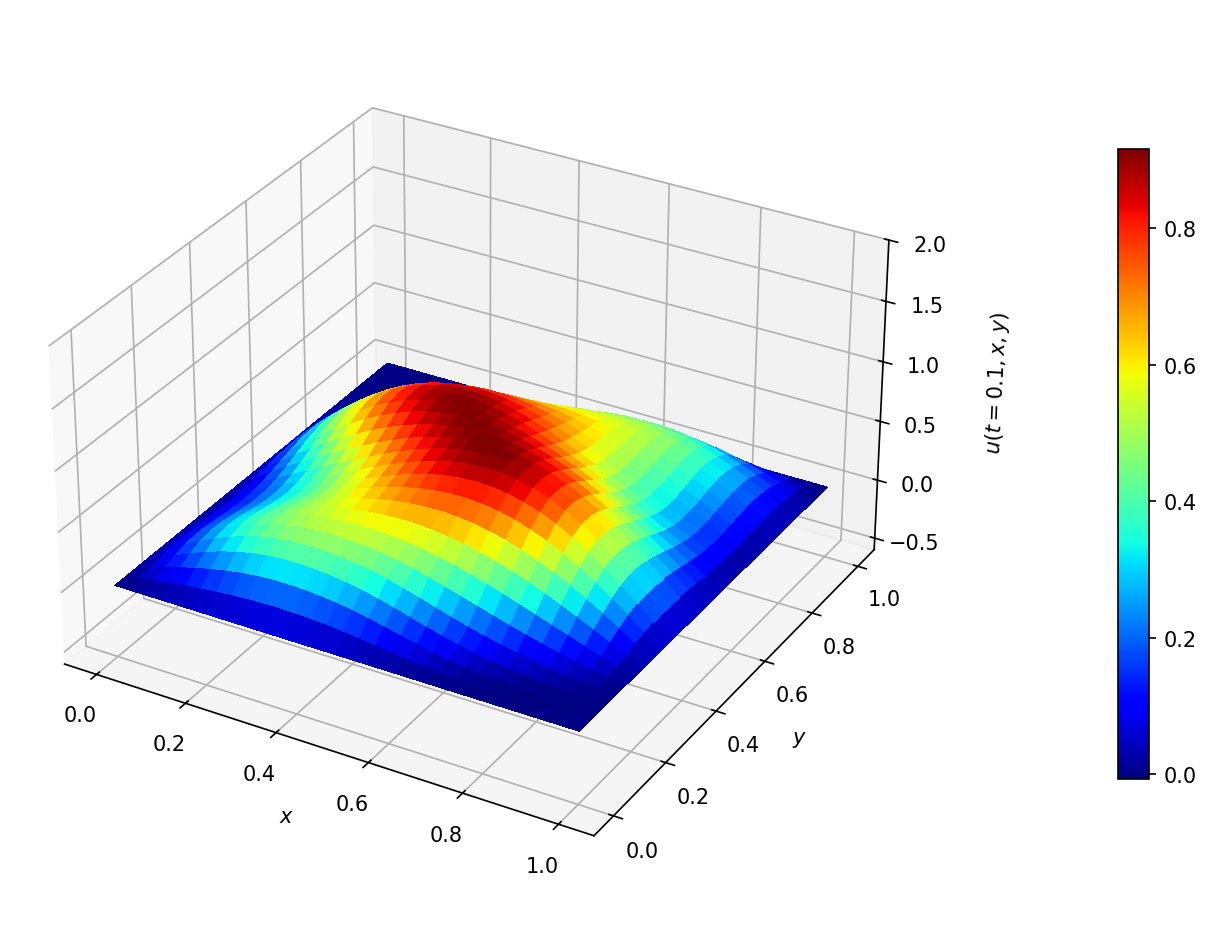

In [14]:
### 3D plot of the solution obtained by our neural network

for t in [0.01, 0.1]:
    # 2D grid
    x = np.linspace(0, 1, N_colloc)
    y = np.linspace(0, 1, N_colloc)
    X, Y = np.meshgrid(x, y)

    # convert grid to NN input (N_collo^2 x 1)
    x_test = torch.tensor(X.reshape(-1, 1), dtype=torch.float32)
    y_test = torch.tensor(Y.reshape(-1, 1), dtype=torch.float32)

    t_test = torch.tensor([[t]] * (N_colloc**2), dtype=torch.float32)

    # prediction: shape (N_colloc^2 ,1)
    u_pred = pde_nn.trial_solution(x_test, y_test, t_test).detach().numpy()

    # reshape to (N_colloc, N_colloc)
    u_pred = u_pred.reshape(N_colloc, N_colloc)

    # surface plot
    fig = plt.figure(figsize=(9, 6), dpi=150)
    ax = fig.add_axes([0.0, 0.0, 1.0, 1.0], projection="3d")
    surf = ax.plot_surface(X, Y, u_pred, rstride=1, cstride=1, cmap=cm.jet,
                    linewidth=0, antialiased=False)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_zlabel(r'$u(t={}, x, y)$'.format(t), labelpad=12)
    ax.set_zlim(-0.6, 2.0)
    ax.set_position([0, 0, 1, 1])
    ax.set_box_aspect((1, 1, 0.6))

    mappable = surf
    cbar = fig.colorbar(mappable, ax=ax, shrink=0.7, pad=0.15)

    # plt.colorbar()
    fig.canvas.draw()
    plt.savefig("surface.png", bbox_inches="tight", dpi=150)
    plt.show()

### Plot of the analytic solution

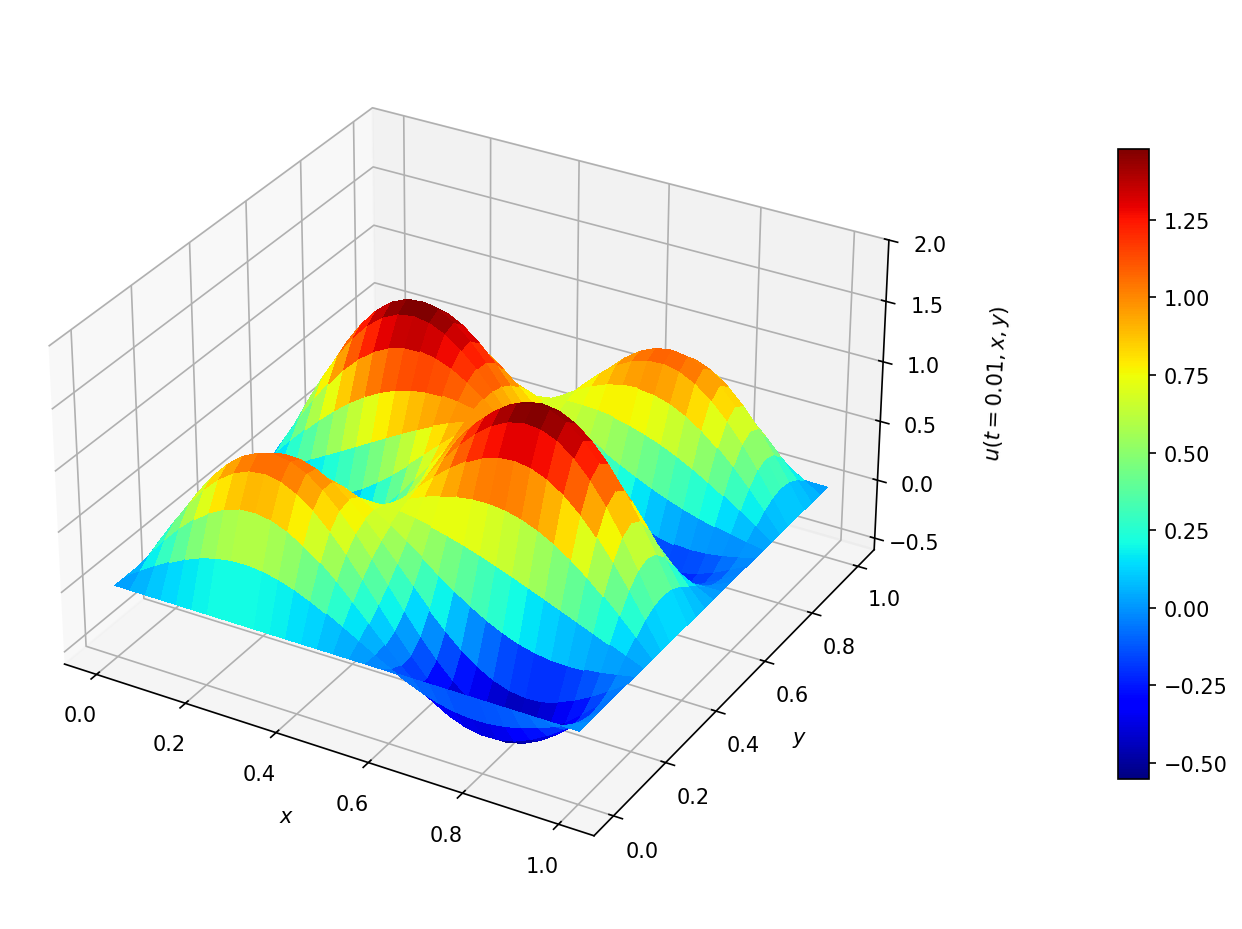

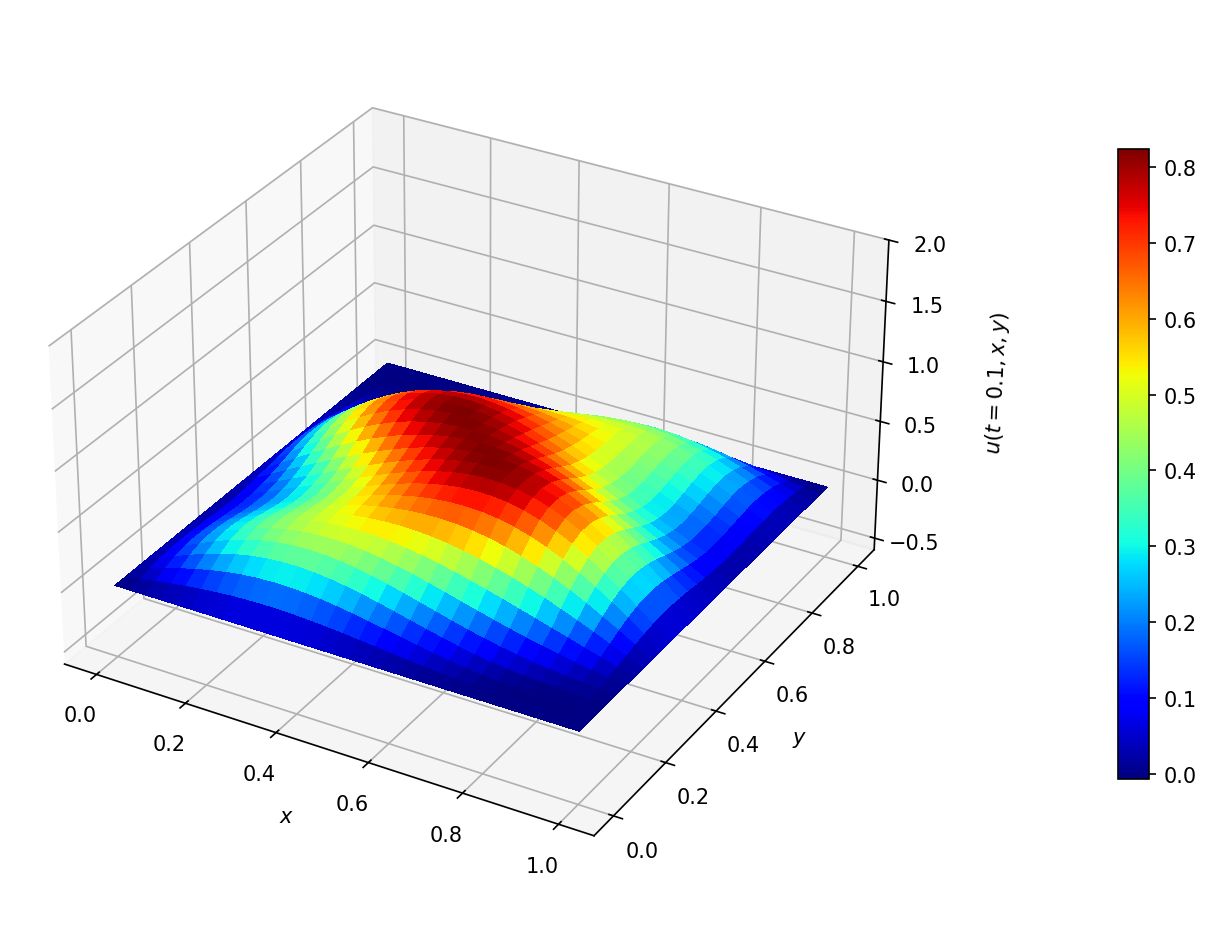

In [16]:
### 3d Plot of the analytic solution for comparison

for t in [0.01, 0.1]:
    # 2D grid
    x = np.linspace(0, 1, N_colloc)
    y = np.linspace(0, 1, N_colloc)
    X, Y = np.meshgrid(x, y)
    
    # convert grid to NN input (400x1)
    x_test = torch.tensor(X.reshape(-1, 1), dtype=torch.float32)
    y_test = torch.tensor(Y.reshape(-1, 1), dtype=torch.float32)

    t_test = torch.tensor([[t]] * (N_colloc**2), dtype=torch.float32)

    # prediction: shape (N_colloc ** 2,1)
    Z = u_analytic(x_test, y_test, t_test).detach().numpy()
    # reshape to (N_colloc, N_colloc)
    Z = Z.reshape(N_colloc, N_colloc)

    # surface plot
    fig = plt.figure(figsize=(9, 6), dpi=150)
    ax = fig.add_axes([0.0, 0.0, 1.0, 1.0], projection="3d")
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.jet,
                    linewidth=0, antialiased=False)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_zlabel(r'$u(t={}, x, y)$'.format(t), labelpad=12)
    ax.set_zlim(-0.6, 2.0)
    ax.set_position([0, 0, 1, 1])
    ax.set_box_aspect((1, 1, 0.6))

    mappable = surf
    cbar = fig.colorbar(mappable, ax=ax, shrink=0.7, pad=0.15)

    # plt.colorbar()
    fig.canvas.draw()
    plt.savefig("surface.png", bbox_inches="tight", dpi=150)
    plt.show()

In [8]:
print(pde_nn.mse())
print(pde_nn.mse(x_test, y_test, t_test))

1.1793979e-05
2.3380302e-05
